# Goal of notebook
- create two dataframes, one for nodes and one for edges
- the nodes dataframe needs everything from create_final network, and adds information on population density, median income, education level, job availability (unclear whether for results or for optimisation), school availability (same here)


In [1]:
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
import osmnx as nx
import shapely
import multiprocess as mp
import numpy as np
import math
from functools import reduce

crs_fr = 2154



In [2]:
# --- From Anastassia
# import packages
%run -i packages.py

# CUSTOM FUNCTION

# define function that creates attribute dictionary for nodes and edges
# (for input to nx.add_edges_from/add_nodes_from)
def make_attr_dict(*args, **kwargs): 
    
    argCount = len(kwargs)
    
    if argCount > 0:
        attributes = {}
        for kwarg in kwargs:
            attributes[kwarg] = kwargs.get(kwarg, None)
        return attributes
    else:
        return None # (if no attributes are given)

In [3]:
#--- Get relevant shapes and data

# GPM outline
GPM = gpd.read_file('data/raw/GPM.geojson').to_crs(crs_fr)

# IRIS codes and shapes 
IRIS_GPM = gpd.read_file('data/raw/IRIS_GPM.geojson')
IRIS_GPM['CODE_IRIS'] = IRIS_GPM['CODE_IRIS'].astype('string')

# Communes (and filter for GPM)
communes = gpd.read_file('data/raw/commune-frmetdrom/COMMUNE_FRMETDROM.shp').to_crs(crs_fr)
communes['point'] = communes['geometry'].centroid
communes = communes.set_geometry('point')
communes_GPM = gpd.sjoin(communes, GPM, how='inner', op='intersects').set_geometry('geometry')
communes_GPM = communes_GPM[['NOM', 'INSEE_COM', 'geometry']]

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


# Number of schools per IRIS

In [4]:
#--- Get education-related amenities from OSM

# Define tags
tags = {'amenity': 'school'}
place_name = 'Grand Paris Metropolis, France'

# Get the data
buildings = ox.geometries_from_place(place_name, tags).reset_index(drop=False)

# Keep relevant columns
col_tokeep = ['osmid', 'geometry', 'amenity', 'name', 'school:FR']
buildings = buildings[col_tokeep].to_crs(IRIS_GPM.crs)
buildings.shape

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_12841/304401160.py:8: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_place(place_name, tags).reset_index(drop=False)


(4337, 5)

In [5]:
#--- Group by type and by IRIS

# Only keep buildings with some sort of name (so they can be checked)
buildings['name'] = buildings['name'].fillna(buildings['school:FR'])
buildings_notnull = buildings.loc[buildings['name'].notnull()].drop_duplicates(subset=['geometry'], keep='first').drop(columns = ['school:FR', 'osmid'])
len(buildings_notnull)

# Prep the tables
buildings_notnull['geometry'] = buildings_notnull['geometry'].centroid
buildings_notnull = buildings_notnull.drop(columns = 'name')

# Perform the spatial join
joined_table = gpd.sjoin(buildings_notnull, IRIS_GPM, how = 'right', predicate='within')

# Find buildings that are close to the border
unmatched_buildings = buildings_notnull[~buildings_notnull.index.isin(joined_table['index_left'])]
buffer_distance = 50 
unmatched_buildings['geometry'] = unmatched_buildings.buffer(buffer_distance)
buffer_gdf = gpd.GeoDataFrame(unmatched_buildings ,geometry='geometry', crs=buildings_notnull.crs)

# Add missing buildings to the table
buffer_joined_table = gpd.sjoin(buffer_gdf, IRIS_GPM, how = 'right')
buffer_joined_table.isnull().sum()
joined_table = pd.concat([joined_table, buffer_joined_table], ignore_index=True).drop(columns = ['index_left'])

# Count the number of each building amenity in each IRIS
pivot_table = joined_table.pivot_table(index='CODE_IRIS', columns='amenity', aggfunc='count', fill_value=0)
pivot_table.columns = pivot_table.columns.map(lambda x: f'{x[1]}_count')
pivot_table = pivot_table.reset_index()

# Add geometry
final_table = pivot_table.merge(IRIS_GPM[['CODE_IRIS', 'geometry']], on='CODE_IRIS', how = 'right').fillna(0)

# turn everything except the geometry to int64 type
final_table.iloc[:, 0:-1] = final_table.iloc[:, 0:-1].astype('int64')
final_table = final_table.loc[:,~final_table.columns.duplicated()].copy()

education_perIRIS = final_table
education_perIRIS.head(2)

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_12841/3253410749.py:35: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  final_table.iloc[:, 0:-1] = final_table.iloc[:, 0:-1].astype('int64')


,CODE_IRIS,school_count,geometry
0,920440109,3,"POLYGON ((648055.600 6866209.000, 648025.400 6..."
1,930270105,1,"POLYGON ((656803.300 6869116.600, 656753.200 6..."


In [6]:
education_perIRIS.dtypes

CODE_IRIS          int64
school_count       int64
geometry        geometry
dtype: object

In [7]:
education_perIRIS.shape

(2666, 3)

# Available jobs per IRIS

In [8]:
df = pd.read_csv('data/raw/etablissements-et-effectifs-salaries-au-niveau-commune-x-ape-last.csv', sep=';')

# Fix the Commune names and codes
df['Code commune'] = df.Commune.apply(lambda x: x[:5])
df['Commune'] = df.Commune.apply(lambda x: x[6:])

# Only keep those in GPM
df_GPM = df.loc[df['EPCI'] == 'Métropole du Grand Paris']

# Clean up a bit
col_todrop  = ['Région', 'Ancienne région', 'Département','EPCI',
       'Secteur NA17', 'Secteur NA38', 'Secteur NA88', 'APE', 'Code région',
       'Code ancienne région', 'Code département',
       'Code EPCI', 'Code APE']
df_GPM = df_GPM.drop(col_todrop, axis = 1)

In [9]:
# One row per commune in GPM
df_GPM_grouped = df_GPM.groupby(['Commune' , 'Zone d\'emploi', 'Code zone d\'emploi', 'Code commune']).sum(numeric_only = True).sort_values(by = 'Effectifs salariés 2018').reset_index().drop(0)
df_GPM_grouped.isnull().sum() #Pick 2021

Commune                         0
Zone d'emploi                   0
Code zone d'emploi              0
Code commune                    0
﻿Code commune                   0
Nombre d'établissements 2006    0
Effectifs salariés 2006         0
Nombre d'établissements 2007    0
Effectifs salariés 2007         0
Nombre d'établissements 2008    0
Effectifs salariés 2008         0
Nombre d'établissements 2009    0
Effectifs salariés 2009         0
Nombre d'établissements 2010    0
Effectifs salariés 2010         0
Nombre d'établissements 2011    0
Effectifs salariés 2011         0
Nombre d'établissements 2012    0
Effectifs salariés 2012         0
Nombre d'établissements 2013    0
Effectifs salariés 2013         0
Nombre d'établissements 2014    0
Effectifs salariés 2014         0
Nombre d'établissements 2015    0
Effectifs salariés 2015         0
Nombre d'établissements 2016    0
Effectifs salariés 2016         0
Nombre d'établissements 2017    0
Effectifs salariés 2017         0
Nombre d'établ

In [10]:
# Finish removing useless columns
col_tokeep = ['Commune', 'Code commune', 'Nombre d\'établissements 2021', 'Effectifs salariés 2021']
df_GPM_grouped = df_GPM_grouped[col_tokeep]

# Fix column types
df_GPM_grouped['Code commune'] = df_GPM_grouped['Code commune'].astype('string')
df_GPM_grouped['Commune'] = df_GPM_grouped['Commune'].astype('string')
df_GPM_grouped.dtypes

Commune                          string
Code commune                     string
Nombre d'établissements 2021    float64
Effectifs salariés 2021         float64
dtype: object

<Axes: title={'center': 'Effectifs salariés 2021'}>

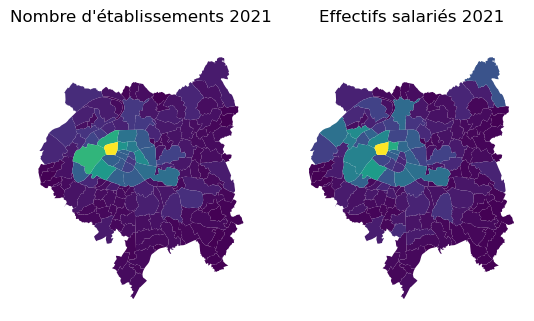

In [11]:
# Add geometry to the communes
df_GPM_grouped_with_geom = pd.merge(df_GPM_grouped, communes_GPM, left_on = 'Code commune', right_on = 'INSEE_COM', how = 'left')
df_GPM_grouped_with_geom = gpd.GeoDataFrame(df_GPM_grouped_with_geom, geometry = 'geometry')

# Final Clean-up
col_tokeep = ['Commune', 'Code commune', 'Nombre d\'établissements 2021',
       'Effectifs salariés 2021', 'geometry']
jobs_per_commune = df_GPM_grouped_with_geom[col_tokeep]

fig, [ax1,ax2] = plt.subplots(1, 2)

# turn off axes
ax1.axis('off')
ax2.axis('off')

ax1.set_title('Nombre d\'établissements 2021')
ax2.set_title('Effectifs salariés 2021')

jobs_per_commune.plot(column = 'Nombre d\'établissements 2021', legend = False, ax = ax1)
jobs_per_commune.plot(column = 'Effectifs salariés 2021', legend = False, ax = ax2)

<Axes: >

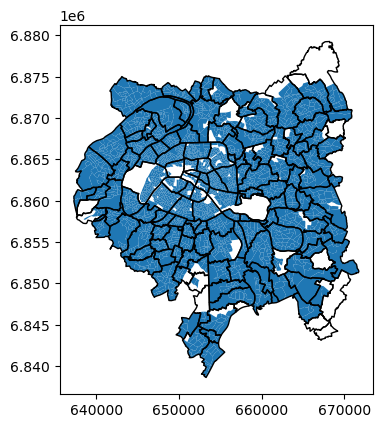

In [12]:
#--- Now on to IRIS level

# Prep the data for spatial join
jobs_per_commune = jobs_per_commune.to_crs(IRIS_GPM.crs)
IRIS_GPM['representative_point'] = IRIS_GPM.representative_point()
IRIS_GPM = IRIS_GPM.set_geometry('representative_point')

# Spatial join
IRIS_communes_GPM = gpd.sjoin(jobs_per_commune, IRIS_GPM, how= 'inner').drop(columns=['index_right'])
IRIS_communes_GPM = IRIS_communes_GPM.set_geometry('geometry_right')

# Plot to check if it worked
ax = plt.axes()
IRIS_communes_GPM.plot(ax=ax)
jobs_per_commune.plot(ax=ax, facecolor='none')

<Axes: >

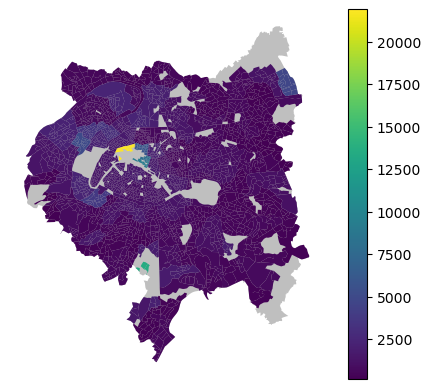

In [13]:
#--- Turning commune-level numbers into IRIS-level numbers

# Calculate the number of IRIS in each commune
IRIS_communes_GPM['Nombre d\'IRIS'] = IRIS_communes_GPM.groupby(['Commune'])['CODE_IRIS'].transform('count')

# Divide the number of jobs in each commune by the number of IRIS in the commune
IRIS_communes_GPM['Effectifs salariés 2021 par IRIS'] = IRIS_communes_GPM['Effectifs salariés 2021'] / IRIS_communes_GPM['Nombre d\'IRIS']
IRIS_communes_GPM['Nombre d\'établissements 2021 par IRIS'] = IRIS_communes_GPM['Nombre d\'établissements 2021'] / IRIS_communes_GPM['Nombre d\'IRIS']

# Plot the number of jobs per IRIS
ax = plt.axes()
ax.axis('off')
GPM.plot(facecolor = 'grey', alpha = 0.5, ax=ax)
IRIS_communes_GPM.plot(column = 'Effectifs salariés 2021 par IRIS',legend = True, ax=ax)


In [14]:
#--- Create the final jobs per IRIS dataset

col_tokeep = ['CODE_IRIS', 'Effectifs salariés 2021 par IRIS', 'Nombre d\'établissements 2021 par IRIS']
jobs_per_IRIS = IRIS_communes_GPM[col_tokeep]
jobs_per_IRIS = jobs_per_IRIS.astype('int64')

jobs_per_IRIS.head(1)

,CODE_IRIS,Effectifs salariés 2021 par IRIS,Nombre d'établissements 2021 par IRIS
4,930330103,225,52


In [15]:
total_jobs_GPM = jobs_per_IRIS['Effectifs salariés 2021 par IRIS'].sum()
total_jobs_GPM

3409213

# Median income per IRIS (MISSING SOURCE OF DATA)

In [39]:
#--- Get IRIS -level data from INSEE
# from: TODO??
df = pd.read_csv('data/raw/IRIS_DATA/BASE_TD_FILO_DISP_IRIS_2019.csv', sep = ';')
df_meta = pd.read_csv('data/raw/IRIS_DATA/meta_BASE_TD_FILO_DISP_IRIS_2019.csv', sep = ';').drop_duplicates(subset = 'COD_VAR')

vars_of_interest = ['IRIS',
                    'DISP_MED19', # Revenu médian (euros) par UC
                    ]

df_meta_vars = df_meta.loc[df_meta['COD_VAR'].isin(vars_of_interest)].drop_duplicates(subset = 'COD_VAR')
median_income_IRIS_GPM = df.loc[(df['IRIS'].isin(IRIS_GPM['CODE_IRIS'])), df_meta_vars['COD_VAR'].values]
median_income_IRIS_GPM.head(1)

,IRIS,DISP_MED19
7178,751010201,30010


In [40]:
#--- Get commune-level data 

# Add geometry column (for matching)
median_income_IRIS_GPM_geom = median_income_IRIS_GPM.merge(IRIS_GPM[['CODE_IRIS', 'geometry']], left_on = 'IRIS', right_on = 'CODE_IRIS', how = 'outer')
median_income_IRIS_GPM_geom = gpd.GeoDataFrame(median_income_IRIS_GPM_geom, geometry = 'geometry')

# Get commune-level data
df = pd.read_csv('data/raw/indic-struct-distrib-revenu-2019-COMMUNES_csv/FILO2019_DISP_COM.csv', sep = ';')
df_meta = pd.read_csv('data/raw/indic-struct-distrib-revenu-2019-COMMUNES_csv/meta_FILO2019_DISP_COM.csv', sep = ';')
vars_of_interest = ['CODGEO', #geographical code
                    'Q219' #median
                    ]

df['CODGEO'] = df['CODGEO'].astype(str)
median_income_commune_GPM = df.loc[ df['CODGEO'].isin(communes_GPM['INSEE_COM'].tolist()), vars_of_interest]

# Add commune geometry to the dataframe
median_income_commune_GPM = median_income_commune_GPM.merge(communes_GPM[['INSEE_COM', 'geometry']], left_on = 'CODGEO', right_on = 'INSEE_COM', how = 'outer').drop(columns = 'INSEE_COM')
median_income_commune_GPM = gpd.GeoDataFrame(median_income_commune_GPM, geometry = 'geometry')    
median_income_commune_GPM.head(2)

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_12841/893220840.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/raw/indic-struct-distrib-revenu-2019-COMMUNES_csv/FILO2019_DISP_COM.csv', sep = ';')


,CODGEO,Q219,geometry
0,75101,34720,"POLYGON ((651927.100 6861781.900, 651911.600 6..."
1,75102,32650,"POLYGON ((652102.700 6863620.200, 652167.800 6..."


In [41]:
#--- Match IRIS and communes

# Prep the data for spatial join
median_income_IRIS_GPM_geom['representative_point'] = median_income_IRIS_GPM_geom.representative_point()
median_income_IRIS_GPM_geom = median_income_IRIS_GPM_geom.set_geometry('representative_point')

# Spatial join
joined = gpd.sjoin(median_income_IRIS_GPM_geom, median_income_commune_GPM, how= 'inner')
joined = joined.set_geometry('geometry')
median_income_IRIS_GPM_geom = median_income_IRIS_GPM_geom.set_geometry('geometry')


In [42]:
#--- Fill-in the missing data
joined['DISP_MED19'] = joined['DISP_MED19'].fillna(joined['Q219'])
median_income_IRIS_GPM_complete = joined[['CODE_IRIS', 'DISP_MED19', 'geometry']]
median_income_IRIS_GPM_complete = median_income_IRIS_GPM_complete.rename(columns = {'DISP_MED19': 'median_income'})

In [45]:
#--- Final clean up
median_income_IRIS_GPM_complete['CODE_IRIS'] = median_income_IRIS_GPM_complete['CODE_IRIS'].astype('int64')
median_income_IRIS_GPM_complete = median_income_IRIS_GPM_complete.drop(columns = 'geometry')

# Education level per IRIS (TOIMPORT/TODO)

In [17]:
#--- Get IRIS -level data from INSEE
# from: TODO??
df = pd.read_csv('data/raw/IRIS_DATA/BASE_TD_FILO_DISP_IRIS_2019.csv', sep = ';')
df_meta = pd.read_csv('data/raw/IRIS_DATA/meta_BASE_TD_FILO_DISP_IRIS_2019.csv', sep = ';').drop_duplicates(subset = 'COD_VAR')

vars_of_interest = ['IRIS',
                    'DISP_MED19', # Revenu médian (euros) par UC
                    ]

df_meta_vars = df_meta.loc[df_meta['COD_VAR'].isin(vars_of_interest)].drop_duplicates(subset = 'COD_VAR')
median_income_IRIS_GPM = df.loc[(df['IRIS'].isin(IRIS_GPM['CODE_IRIS'])), df_meta_vars['COD_VAR'].values]
median_income_IRIS_GPM.head(1)

# Active/school/total population and population density per IRIS

In [16]:
# From https://www.insee.fr/fr/statistiques/6456153?sommaire=6456166#dictionnaire
#--- Get data on the age ranges of the population 

df = pd.read_csv('data/raw/struct-pop-2019/struct-pop-2019.CSV', sep = ';')
df_meta = pd.read_csv('data/raw/struct-pop-2019/meta-struct-pop-2019.CSV', sep = ';')
df['IRIS'] = df['IRIS'].astype('string')

vars_of_interest = ['IRIS',
                    'P19_POP', # Total population
                    'P19_POP0305', # Pop 3-5 y.o -> goes to school
                    'P19_POP0610', # Pop 6-10 y.o -> goes to school
                    'P19_POP1117', # Pop 11-17 y.o -> goes to school 
                    'P19_POP1824', # Pop 18-24 y.o -> goes to work
                    'P19_POP2539', # Pop 25-39 y.o -> goes to work
                    'P19_POP4054', # Pop 40-54 y.o -> goes to work
                    'P19_POP5564', # Pop 55-64 y.o -> goes to work  
                    'COM'                
                    ]

df_meta_vars = df_meta.loc[df_meta['COD_VAR'].isin(vars_of_interest)].drop_duplicates(subset = 'COD_VAR')
df_narrow_IRIS = df.loc[(df['IRIS'].isin(IRIS_GPM['CODE_IRIS'])), df_meta_vars['COD_VAR'].values]

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_12841/669537842.py:4: DtypeWarning: Columns (0,1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/raw/struct-pop-2019/struct-pop-2019.CSV', sep = ';')


In [17]:
# Combine age ranges into school and active population
df_narrow_IRIS['school_pop_19'] = df_narrow_IRIS['P19_POP0305'] + df_narrow_IRIS['P19_POP0610'] + df_narrow_IRIS['P19_POP1117']
df_narrow_IRIS['active_pop_19'] = df_narrow_IRIS['P19_POP1824'] + df_narrow_IRIS['P19_POP2539'] + df_narrow_IRIS['P19_POP4054'] + df_narrow_IRIS['P19_POP5564']

# Remove useless columns
age_range_IRIS = df_narrow_IRIS.drop(columns = ['P19_POP0305', 'P19_POP0610', 'P19_POP1117',
                                                'P19_POP1824', 'P19_POP2539', 'P19_POP4054', 'P19_POP5564']) 

# Fill in missing data (median of the commune, same communes missing for both variables)
P19_pop_commune_median = age_range_IRIS.loc[age_range_IRIS['COM'] == 94022]['P19_POP'].median()
P19_pop_school_commune_median = age_range_IRIS.loc[age_range_IRIS['COM'] == 94022]['school_pop_19'].median()
P19_pop_active_commune_median = age_range_IRIS.loc[age_range_IRIS['COM'] == 94022]['active_pop_19'].median()
row1 = ['940220101', P19_pop_commune_median, P19_pop_school_commune_median, P19_pop_active_commune_median]
row2 = ['940220103', P19_pop_commune_median, P19_pop_school_commune_median, P19_pop_active_commune_median]
row3= ['940220104', P19_pop_commune_median, P19_pop_school_commune_median, P19_pop_active_commune_median]
df2 = pd.DataFrame([row1, row2, row3],
                   columns=['IRIS', 'P19_POP', 'school_pop_19', 'active_pop_19'])
age_range_IRIS = pd.concat([age_range_IRIS, df2]).drop(columns = 'COM').reset_index(drop=True)

age_range_IRIS['IRIS'] = age_range_IRIS['IRIS'].astype('string')
age_range_IRIS.shape


(2666, 4)

In [18]:
age_range_IRIS_geom = age_range_IRIS.merge(IRIS_GPM, left_on = 'IRIS', right_on = 'CODE_IRIS')
age_range_IRIS_geom = gpd.GeoDataFrame(age_range_IRIS_geom, geometry = 'geometry')

In [19]:
#--- Add population density

# Calculate the area of each polygon
age_range_IRIS_geom['area'] = age_range_IRIS_geom['geometry'].area / 1000000 #make per km2

# Calculate the population density
age_range_IRIS_geom['pop_density'] = age_range_IRIS_geom['P19_POP'] / age_range_IRIS_geom['area']
age_range_IRIS_geom['active_pop_density'] = age_range_IRIS_geom['active_pop_19'] / age_range_IRIS_geom['area']
age_range_IRIS_geom['school_pop_density'] = age_range_IRIS_geom['school_pop_19'] / age_range_IRIS_geom['area']

age_range_IRIS_geom.head(2)

,P19_POP,IRIS,school_pop_19,active_pop_19,CODE_IRIS,geometry,representative_point,area,pop_density,active_pop_density,school_pop_density
0,949.437277,751010101,120.926298,643.391695,751010101,"POLYGON ((652130.300 6862122.400, 652126.100 6...",POINT (651967.902 6862262.950),0.064002,14834.503153,10052.687376,1889.415542
1,2090.235257,751010201,150.158591,1538.800562,751010201,"POLYGON ((652203.200 6862692.000, 652214.400 6...",POINT (652222.135 6862546.900),0.079516,26287.087669,19352.168679,1888.415213


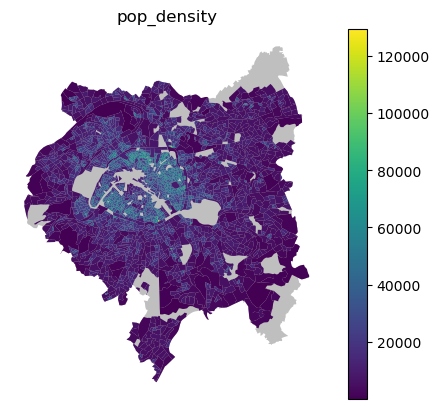

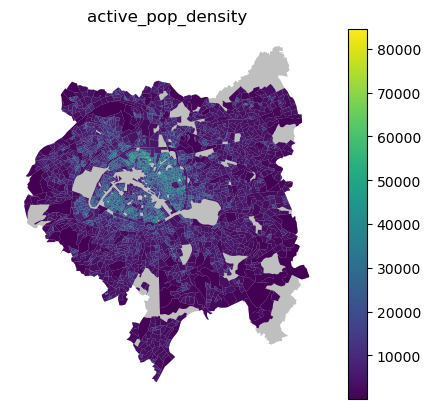

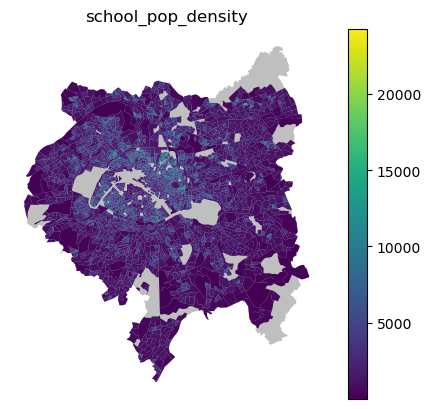

In [20]:
# Plot everything
col_toplot =['pop_density',
            'active_pop_density',
            'school_pop_density'
            ]

for col in col_toplot:
    ax = plt.axes()
    ax.axis('off')
    GPM.to_crs(crs_fr).plot(facecolor = 'grey', alpha = 0.5, ax=ax)
    age_range_IRIS_geom.plot(column = col, legend = True, ax=ax)

    plt.title(col)
    plt.savefig(f'./figures/{col}.png')
    plt.show()

In [21]:
age_range_IRIS_geom['CODE_IRIS'] = age_range_IRIS_geom['IRIS'].astype('int64')
age_range_IRIS_geom.dtypes

P19_POP                  float64
IRIS                      string
school_pop_19            float64
active_pop_19            float64
CODE_IRIS                  int64
geometry                geometry
representative_point    geometry
area                     float64
pop_density              float64
active_pop_density       float64
school_pop_density       float64
dtype: object

# Combine, clean-up and save (TOFIX)

In [47]:
#--- Join all socio-economic dataframes
dataframes = [education_perIRIS, jobs_per_IRIS, age_range_IRIS_geom, median_income_IRIS_GPM_complete]

all_socioeconomic = reduce(lambda  left,right: pd.merge(left, right, on=['CODE_IRIS'], how='outer'), dataframes)

all_socioeconomic.isnull().sum()

CODE_IRIS                                0
school_count                             0
geometry_x                               0
Effectifs salariés 2021 par IRIS         0
Nombre d'établissements 2021 par IRIS    0
P19_POP                                  0
IRIS                                     0
school_pop_19                            0
active_pop_19                            0
geometry_y                               0
representative_point                     0
area                                     0
pop_density                              0
active_pop_density                       0
school_pop_density                       0
median_income                            0
dtype: int64

In [25]:
#--- Import the nodes dataframe from the network

nodes = pd.read_csv('data/clean/initial_network_nodes_complete.csv')
nodes['CODE_IRIS'] = nodes['CODE_IRIS'].astype('Int64').fillna(0)
nodes.head()

,osmid,y,x,geometry,nodetype,centroid,RER,CODE_IRIS,attr_dict
0,0,48.895206,2.289280,POINT (2.289279563873589 48.89520553992178),both,True,False,920440109,"{'lat': 2.289279563873589, 'lon': 48.895205539..."
1,1,48.922227,2.402726,POINT (2.4027264302614983 48.922226718338436),both,True,False,930270105,"{'lat': 2.4027264302614983, 'lon': 48.92222671..."
2,2,48.892245,2.374425,POINT (2.3744245801487915 48.89224524698847),both,True,False,751197316,"{'lat': 2.3744245801487915, 'lon': 48.89224524..."
3,3,48.888659,2.307418,POINT (2.3074182128486482 48.88865941819315),both,True,False,751176716,"{'lat': 2.3074182128486482, 'lon': 48.88865941..."
4,4,48.765645,2.311259,POINT (2.3112588582883213 48.765644720777445),both,True,False,920020104,"{'lat': 2.3112588582883213, 'lon': 48.76564472..."


In [26]:
#--- Combine nodes and socioeconomic dataframes based on CODE_IRIS

nodes_with_socioeconomic = pd.merge(nodes, all_socioeconomic, on='CODE_IRIS', how='left')
nodes_with_socioeconomic.isnull().sum()


osmid                                         0
y                                             0
x                                             0
geometry                                      0
nodetype                                      0
centroid                                      0
RER                                           0
CODE_IRIS                                     0
attr_dict                                     0
school_count                             115512
geometry_x                               115512
Effectifs salariés 2021 par IRIS         115512
Nombre d'établissements 2021 par IRIS    115512
P19_POP                                  115512
IRIS                                     115512
school_pop_19                            115512
active_pop_19                            115512
geometry_y                               115512
representative_point                     115512
area                                     115512
pop_density                             

In [27]:
# Clean up the columns
col_tokeep = ['osmid', 'y', 'x', 'geometry', 'nodetype', 'centroid', 'RER',
       'CODE_IRIS', 'attr_dict', 'school_count', 'Effectifs salariés 2021 par IRIS', 'P19_POP', 
       'school_pop_19', 'active_pop_19', 'area', 'pop_density', 'active_pop_density', 'school_pop_density',
       'median_income']

nodes_with_socioeconomic_final = nodes_with_socioeconomic[col_tokeep]

# Rename columns

nodes_with_socioeconomic_final = nodes_with_socioeconomic_final.rename(columns = {'Effectifs salariés 2021 par IRIS': 'num_jobs'})

nodes_with_socioeconomic_final.head(1)

,osmid,y,x,geometry,nodetype,centroid,RER,CODE_IRIS,attr_dict,school_count,num_jobs,P19_POP,school_pop_19,active_pop_19,area,pop_density,active_pop_density,school_pop_density
0,0,48.895206,2.28928,POINT (2.289279563873589 48.89520553992178),both,True,False,920440109,"{'lat': 2.289279563873589, 'lon': 48.895205539...",3.0,2929.0,2727.643265,423.953213,1763.279401,0.082981,32870.775713,21249.245615,5109.051893


In [28]:
#--- Save the results 
nodes_with_socioeconomic_final.to_csv('data/clean/initial_network_nodes_complete.csv', index = False)